# Optimización de Portafolio en Python

Optimizacion de un Portafolio con Oro, Nikkei 225 y SP-500 como activos solidos en un entorno de alta inflación

### Obtención de Datos e Importación de Librerias

Cargar Yahoo Finance, matplotlib y numpy; Descargar datos de precios desde el 1 de enero de 2014 al 1 de enero de 2024

In [117]:
import yfinance as yf
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from scipy.optimize import minimize

data = yf.download(['GC=F', '^N225', '^GSPC'], start='2014-01-01', end='2024-01-01', auto_adjust=False)['Close']
data.columns = ["Oro", "SP-500", "Nikkei-225"]

[*********************100%***********************]  3 of 3 completed


In [118]:
data.head()

,Oro,SP-500,Nikkei-225
Date,,,
2014-01-02,1225.000000,1831.979980,NaN
2014-01-03,1238.400024,1831.369995,NaN
2014-01-06,1237.800049,1826.770020,15908.879883
2014-01-07,1229.400024,1837.880005,15814.370117
2014-01-08,1225.300049,1837.489990,16121.450195


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

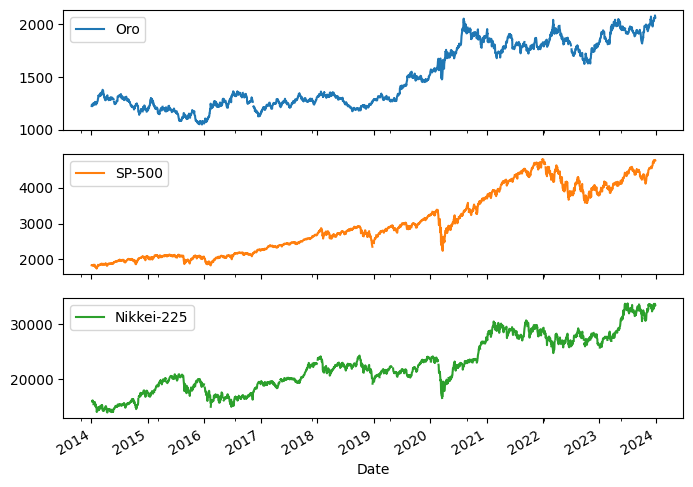

In [119]:
data.plot(figsize = (8,6), subplots=True)

#### Calculando Retornos

In [120]:
data.pct_change()

,Oro,SP-500,Nikkei-225
Date,,,
2014-01-02,NaN,NaN,NaN
2014-01-03,0.010939,-0.000333,NaN
2014-01-06,-0.000484,-0.002512,NaN
2014-01-07,-0.006786,0.006082,-0.005941
2014-01-08,-0.003335,-0.000212,0.019418
...,...,...,...
2023-12-25,0.000000,0.000000,0.002562
2023-12-26,0.000535,0.004232,0.001558
2023-12-27,0.011515,0.001430,0.011271


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

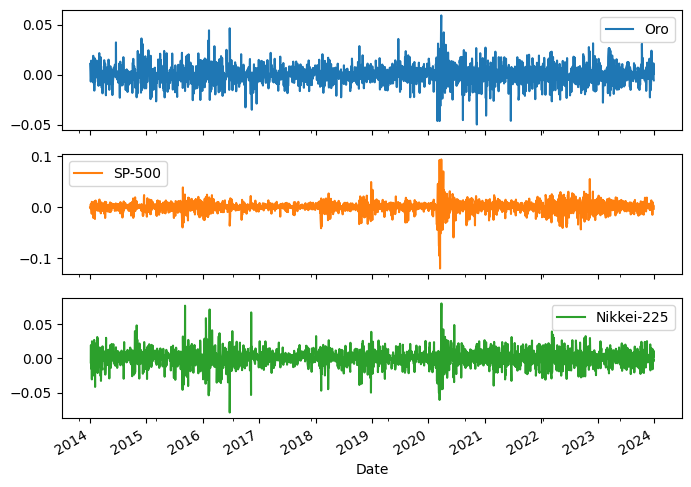

In [121]:
data.pct_change().plot(figsize = (8,6), subplots=True)

In [122]:
#Calcular Retornos Diarios
retornos_diarios = data.pct_change()

#Calcular Rendimiento Anualizado
rendimiento_anualizado = (1 + retornos_diarios.mean()) ** 252 - 1

#Mostrar Resultado
print("Rendimiento Anual: Oro {:.2%} SP-500 {:.2%} Nikkei {:.2%}".format(rendimiento_anualizado[0], rendimiento_anualizado[1], rendimiento_anualizado[2] ))

Rendimiento Anual: Oro 6.28% SP-500 11.43% Nikkei 9.53%


In [123]:
#Calcular Volatilidad
volatilidad_anualizada = retornos_diarios.std() * (252 ** 0.5)

#Mostrar Resultado
print("Volatilidad Anual:  Oro {:.2%} SP-500 {:.2%} Nikkei {:.2%}".format(volatilidad_anualizada[0], volatilidad_anualizada[1], volatilidad_anualizada[2]))

Volatilidad Anual:  Oro 14.36% SP-500 17.46% Nikkei 19.37%


### Optimizacion de Portafolios

In [124]:
#Calcular la Matriz de Covarianza

covarianzas_diarias = retornos_diarios.cov()
covarianza_anualizada = covarianzas_diarias * 252


In [125]:
#Generar Portafolios

rendimientos = []
riesgos = []
portafolios = []

pesos_oro = np.linspace(0, 0.99, 100)
pesos_nikkei = np.linspace(0, 0.99, 100)
for po in pesos_oro:
    for pp in pesos_nikkei:
        w1 = po
        w2 = pp
        w3 = 1 - w1 - w2
            
        pesos = np.array([w1, w2, w3])

        #Calcular Rendimiento
        rendimiento = np.dot(pesos, rendimiento_anualizado)

        #Calcular Riesgo 
        riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianza_anualizada, pesos)))

        #Guardar Resultados
        rendimientos.append(rendimiento)
        riesgos.append(riesgo)
        portafolios.append(pesos)

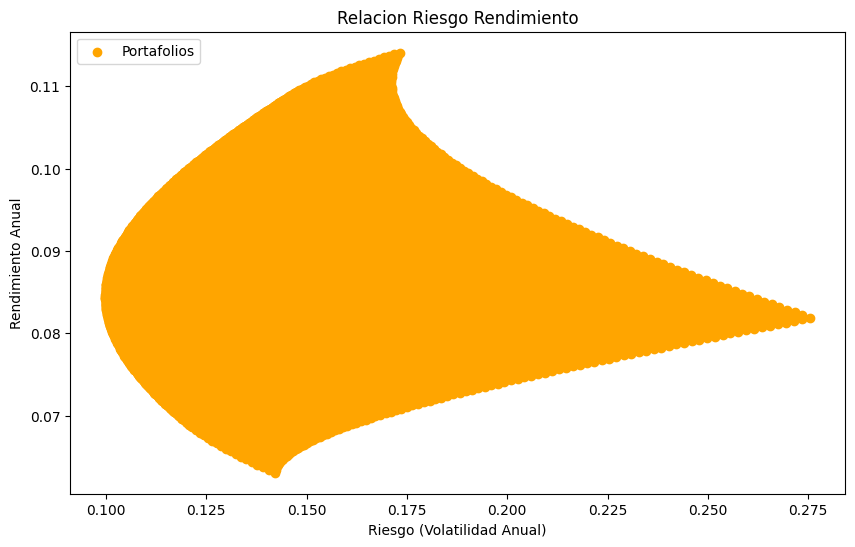

In [126]:
#Graficar Frontera Eficiente
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Volatibilidad Mínima

In [127]:
#Función Objetivo: Minimizar la varianza del Portafolio

def varianza_minima(w, cov):
    return np.dot(w.T, np.dot(cov, w))

In [128]:
#Restricciones: Pesos deben sumar 1

restricciones = (
    {"type": "eq", "fun": lambda w: np.sum(w) -1}
)

In [129]:
#limites: deben estar entre 0 y 1
limites = [(0, 1) for _ in range(len(covarianzas_diarias))]

In [130]:
#Pesos Iniciales
pesos_iniciales = np.array([0.33, 0.33, 0.34])

In [131]:
#Optimización
resultado = minimize(
    varianza_minima,
    pesos_iniciales,
    args=(covarianza_anualizada,),
    constraints = restricciones, 
    bounds = limites,
    method = "SLSQP"
)

In [132]:
#Peso Varianza Minima
pesos_min_var = resultado.x
print("Pesos Varianza Minima: Oro {:.2%} SP-500 {:.2%} Nikkei-225 {:.2%}".format(pesos_min_var[0], pesos_min_var[1], pesos_min_var[2]))

Pesos Varianza Minima: Oro 48.88% SP-500 28.78% Nikkei-225 22.34%


In [133]:
rendimiento_min_var = np.dot(pesos_min_var, rendimiento_anualizado)
riesgo_min_var = np.sqrt(np.dot(pesos_min_var.T, np.dot(covarianza_anualizada, pesos_min_var)))

print("Rendimiento: {:.2%}".format(rendimiento_min_var))
print("Riesgo: {:.2%}".format(riesgo_min_var))

Rendimiento: 8.48%
Riesgo: 9.99%


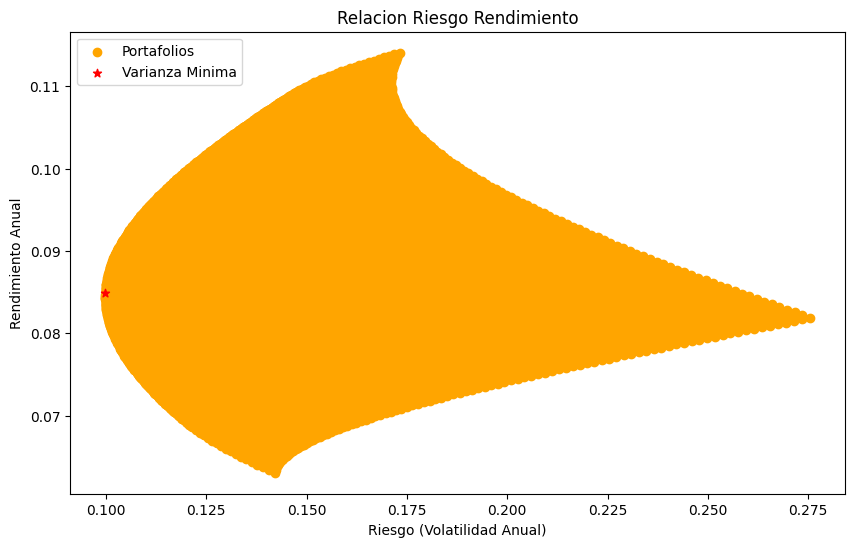

In [134]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, label="Varianza Minima", color="red", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Ratio de Sharpe

In [135]:
#Tasa Libre de Riesgo 
tasa_libre_riesgo = 0.03

def rendimiento_riesgo(pesos, retornos, covarianzas):
    rendimiento = np.dot(pesos, retornos)
    riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianzas, pesos)))
    return rendimiento, riesgo

def ratio_sharpe(pesos, retornos, covarianzas, tasa_libre_riesgo):
    rendimiento, riesgo = rendimiento_riesgo(pesos, retornos, covarianzas)
    return - (rendimiento - tasa_libre_riesgo) / riesgo

In [136]:
#Optimizacion

resultado = minimize(
    ratio_sharpe,
    pesos_iniciales,
    args=(rendimiento_anualizado, covarianza_anualizada, tasa_libre_riesgo),
    constraints=restricciones,
    bounds=limites,
    method="SLSQP"
)

pesos_sharpe = resultado.x 
rendimiento_sharpe, riesgo_sharpe = rendimiento_riesgo(pesos_sharpe, rendimiento_anualizado, covarianza_anualizada)
print("Pesos Optimos Sharpe Oro {:.2%} SP-500 {:.2%} Nikkei-225 {:.2%}".format(pesos_sharpe[0], pesos_sharpe[1], pesos_sharpe[2]))
print("Rendimiento Sharpe {:.2%}".format(rendimiento_sharpe))
print("Riesgo Sharpe {:.2%}".format(riesgo_sharpe))

Pesos Optimos Sharpe Oro 29.97% SP-500 45.16% Nikkei-225 24.87%
Rendimiento Sharpe 9.41%
Riesgo Sharpe 10.83%


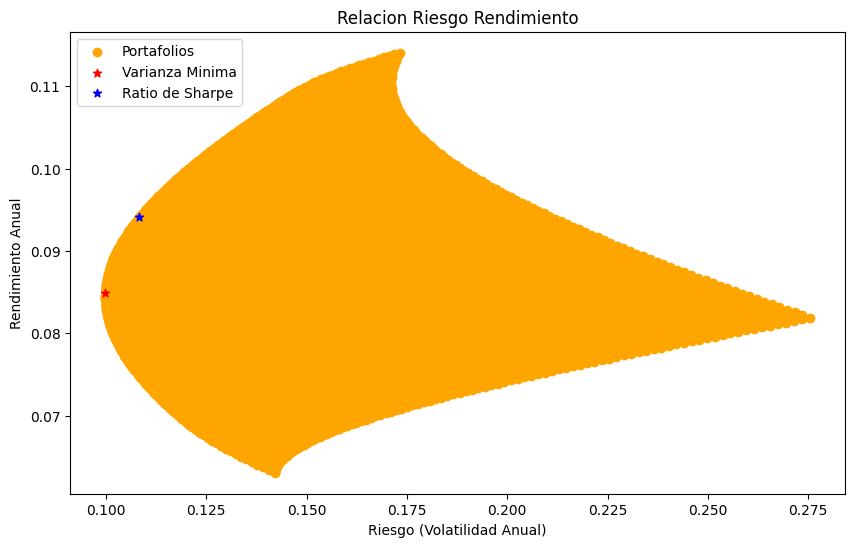

In [137]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, label="Varianza Minima", color="red", marker="*")
plt.scatter(riesgo_sharpe, rendimiento_sharpe, label="Ratio de Sharpe", color="blue", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Ratio de Sortino

In [138]:
#Funcion para calcular el riesgo de perdidas
def downside_risk(pesos, retornos):
    rendimiento_portafolio = np.dot(retornos, pesos)

    #Calculo Rendimiento Negativo
    downside = rendimiento_portafolio[rendimiento_portafolio < 0]
    if len(downside) == 0:
        return 0
    
    return np.std(downside)

#Funcion Ratio Sortino
def ratio_sortino(pesos, retornos, tasa_libre_riesgo):
    rendimiento = (1 + np.dot(pesos, retornos.mean())) ** 252
    downside = downside_risk(pesos, retornos)
    if downside == 0:
        return np.inf 
    
    return -(rendimiento - tasa_libre_riesgo) / downside


In [139]:
#Optimización
resultado = minimize(
    ratio_sortino,
    pesos_iniciales,
    args=(retornos_diarios, tasa_libre_riesgo),
    constraints=restricciones,
    bounds=limites,
    method="SLSQP"
)

pesos_sortino = resultado.x
rendimiento_sortino, riesgo_sortino = rendimiento_riesgo(pesos_sortino, rendimiento_anualizado, covarianza_anualizada)
print("Pesos Optimos Sortino: Oro {:.2%} SP-500 {:.2%} Nikkei-225 {:.2%}".format(pesos_sortino[0], pesos_sortino[1], pesos_sortino[2]))
print("Rendimiento Sortino {:.2%}".format(rendimiento_sortino))
print("Riesgo Sortino {:.2%}".format(riesgo_sortino))

Pesos Optimos Sortino: Oro 52.53% SP-500 20.66% Nikkei-225 26.81%
Rendimiento Sortino 8.21%
Riesgo Sortino 10.07%


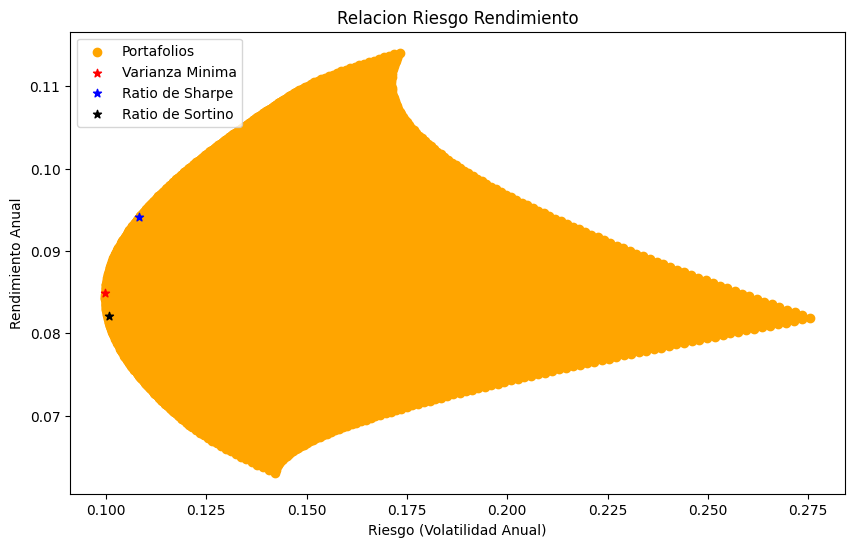

In [140]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, label="Varianza Minima", color="red", marker="*")
plt.scatter(riesgo_sharpe, rendimiento_sharpe, label="Ratio de Sharpe", color="blue", marker="*")
plt.scatter(riesgo_sortino, rendimiento_sortino, label="Ratio de Sortino", color="black", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Comparación Rendimiento Historico

In [141]:
historico = pd.DataFrame()

historico['Minima Varianza'] = data.pct_change().dot(pesos_min_var)
historico['Ratio Sharpe'] = data.pct_change().dot(pesos_sharpe)
historico['Ratio Sortino'] = data.pct_change().dot(pesos_sortino)

historico = historico.dropna()
historico.head()

,Minima Varianza,Ratio Sharpe,Ratio Sortino
Date,,,
2014-01-07,-0.002894,-0.000764,-0.003901
2014-01-08,0.002647,0.003733,0.003411
2014-01-09,-0.001646,-0.002584,-0.002224
2014-01-10,0.008029,0.005781,0.008447
2014-01-13,-0.001972,-0.004670,-0.000829


C:\Users\AXEL ALEMAN\AppData\Local\Temp\ipykernel_26540\2102786670.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


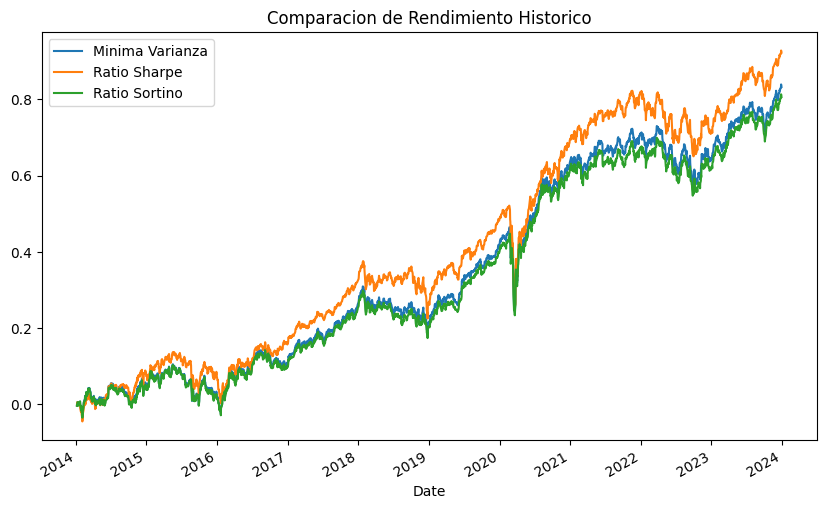

In [142]:
#Graficar

fig, ax = plt.subplots(figsize=(10,6))
historico.cumsum().plot(ax=ax)
ax.set_title("Comparacion de Rendimiento Historico")
fig.show()

In [143]:
print("Rendimiento Final")
rendimiento_final = historico.cumsum().tail(1)
print("Minima Varianza: {:.2%}".format(rendimiento_final['Minima Varianza'].iloc[0]))
print("Ratio de Sharpe: {:.2%}".format(rendimiento_final['Ratio Sharpe'].iloc[0]))
print("Ratio de Sortino: {:.2%}".format(rendimiento_final['Ratio Sortino'].iloc[0]))

Rendimiento Final
Minima Varianza: 83.23%
Ratio de Sharpe: 92.25%
Ratio de Sortino: 80.60%


### Comparación de Rendimiento Actual

In [144]:
new_data = yf.download(['GC=F', '^N225', '^GSPC'], start='2024-01-01', end='2026-02-01', auto_adjust=False)['Close']

[*********************100%***********************]  3 of 3 completed


In [145]:
actual = pd.DataFrame()

actual['Minima Varianza'] = new_data.pct_change().dot(pesos_min_var)
actual['Ratio Sharpe'] = new_data.pct_change().dot(pesos_sharpe)
actual['Ratio Sortino'] = new_data.pct_change().dot(pesos_sortino)

actual = actual.dropna()
actual.head()

,Minima Varianza,Ratio Sharpe,Ratio Sortino
Date,,,
2024-01-05,0.001148,0.001505,0.001121
2024-01-08,0.000280,0.004056,-0.001147
2024-01-09,0.002109,0.002177,0.002742
2024-01-10,0.004987,0.006861,0.005341
2024-01-11,0.001963,0.002991,0.002674


C:\Users\AXEL ALEMAN\AppData\Local\Temp\ipykernel_26540\2543245500.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


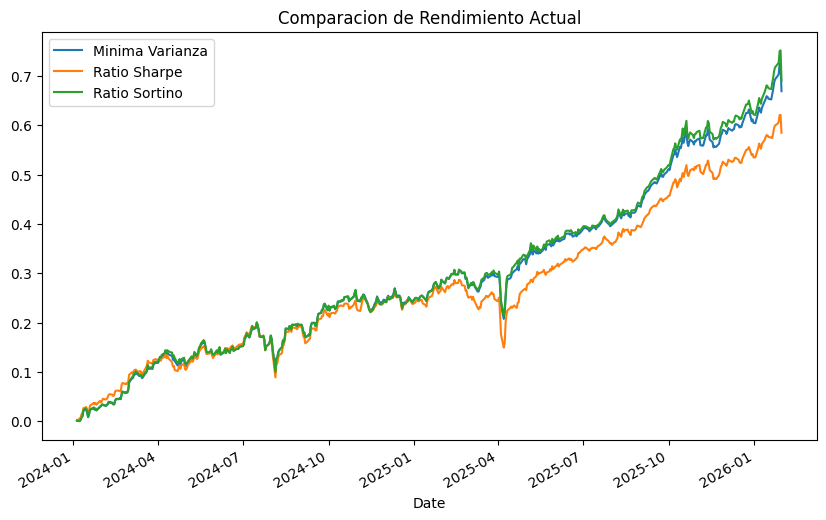

In [146]:
#Graficar

fig, ax = plt.subplots(figsize=(10,6))
actual.cumsum().plot(ax=ax)
ax.set_title("Comparacion de Rendimiento Actual")
fig.show()

In [147]:
print("Rendimiento Final")
rendimiento_final = actual.cumsum().tail(1)
print("Minima Varianza: {:.2%}".format(rendimiento_final['Minima Varianza'].iloc[0]))
print("Ratio de Sharpe: {:.2%}".format(rendimiento_final['Ratio Sharpe'].iloc[0]))
print("Ratio de Sortino: {:.2%}".format(rendimiento_final['Ratio Sortino'].iloc[0]))

Rendimiento Final
Minima Varianza: 66.92%
Ratio de Sharpe: 58.49%
Ratio de Sortino: 69.12%
